In [1]:
import argparse
import datetime
import logging
import os
import sys
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

In [4]:
import utils
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Network

In [5]:
class AdaptiveLinear(nn.Linear):
    r"""Applies a linear transformation to the input data as follows
    :math:`y = naxA^T + b`.
    More details available in Jagtap, A. D. et al. Locally adaptive
    activation functions with slope recovery for deep and
    physics-informed neural networks, Proc. R. Soc. 2020.

    Parameters
    ----------
    in_features : int
        The size of each input sample
    out_features : int 
        The size of each output sample
    bias : bool, optional
        If set to ``False``, the layer will not learn an additive bias
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice 
        (self.A is the learnable parameter which is initialized by the 
        self.adaptive rate. To create a learnable parameter for each neuron, 
        it multiplies the self.adaptive rate to the number of input features.)
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, in_features, out_features, bias=True, adaptive_rate=None, adaptive_rate_scaler=None):
        super(AdaptiveLinear, self).__init__(in_features, out_features, bias)
        self.adaptive_rate = adaptive_rate
        self.adaptive_rate_scaler = adaptive_rate_scaler
        if self.adaptive_rate:
            self.A = nn.Parameter(self.adaptive_rate * torch.ones(self.in_features))
            if not self.adaptive_rate_scaler:
                self.adaptive_rate_scaler = 10.0
            
    def forward(self, input):
        if self.adaptive_rate:
            return nn.functional.linear(self.adaptive_rate_scaler * self.A * input, self.weight, self.bias)
        return nn.functional.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return (
            f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, '
            f'adaptive_rate={self.adaptive_rate is not None}, adaptive_rate_scaler={self.adaptive_rate_scaler is not None}'
        )

class Net(nn.Module):
    r"""Neural approximator for the unknown function that is supposed
    to be solved.

    More details available in Raissi, M. et al. Physics-informed neural
    networks: A deep learning framework for solving forward and inverse
    problems involving nonlinear partial differential equations, J.
    Comput. Phys. 2019.

    Parameters
    ----------
    sizes : list
        Each element represents the number of neuron per layer
    activation : callable 
        Activation function
    dropout_rate : float, optional
        Dropout rate for regulrization during training process and
        uncertainty quantification by means of Monte Carlo dropout
        procedure while performing evaluation
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, sizes, activation, dropout_rate=0.0, adaptive_rate=None, adaptive_rate_scaler=None):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(
            *[Net.linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler)
            for in_features, out_features in zip(sizes[:-1], sizes[1:-1])],     
            AdaptiveLinear(sizes[-2], sizes[-1]) # output layer is regular linear transformation
            )
        
    def forward(self, x):
        return self.regressor(x)

    @staticmethod
    def linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler):
        activation_dispatcher = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU()],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()],
            ['sigmoid', nn.Sigmoid()],
            # ['swish', Swish()]
        ])
        return nn.Sequential(
            AdaptiveLinear(in_features, out_features, adaptive_rate=adaptive_rate, adaptive_rate_scaler=adaptive_rate_scaler),
            activation_dispatcher[activation],
            nn.Dropout(dropout_rate),
            )

In [6]:
IPINN = Net(
    sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0
    )
IPINN.cuda()
print('done')

Net(
  (regressor): Sequential(
    (0): Sequential(
      (0): AdaptiveLinear(in_features=2, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (2): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (3): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (4): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2)

# Train

In [7]:
n_epochs = 5000
lossFunction = nn.MSELoss()
lr = 3e-5
optimizer = optim.Adam(IPINN.parameters(), lr=lr)

x_f_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_label_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_data_s = torch.tensor(0.).float().to(device).requires_grad_(True)
optimizer_adam_weight = optim.Adam([x_f_s] + [x_label_s] + [x_data_s], lr=lr)

In [8]:
import time
import torch.autograd as tgrad

loss_hist = []
min_train_loss = float("inf")  # Initialize with a large value
final_model = None
start_time = time.time()

# tqdm.tqdm(range(n_epochs), desc='[Training procedure]', ascii=True, total=n_epochs)
for _ in range(n_epochs):
    
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
    
    # pde residual loss
    y1_hat = IPINN(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                    create_graph=True, only_inputs=True, allow_unused=True)[0]
    S1 = n_st_train[:, 1].view(-1, 1)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # boudary condition loss
    y21_hat = IPINN(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y21_hat)
    
    # data Round
    y3_hat = IPINN(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # slope recovery term
    local_recovery_terms = torch.tensor([torch.mean(IPINN.regressor[layer][0].A.data) for layer in range(len(IPINN.regressor) - 1)])
    slope_recovery_term = 1 / torch.mean(torch.exp(local_recovery_terms))
    
    # update the weight
    optimizer_adam_weight.zero_grad()
    loss = torch.exp(-x_f_s) * pde_loss.detach() + x_f_s + torch.exp(-x_label_s) * bc_loss.detach() + x_label_s + torch.exp(-x_data_s) * data_loss.detach() + x_data_s + slope_recovery_term
    loss.backward()
    optimizer_adam_weight.step()
    
    # update the neural network parameters
    optimizer.zero_grad()
    total_loss = torch.exp(-x_f_s.detach()) * pde_loss + torch.exp(-x_label_s.detach()) * bc_loss + torch.exp(-x_data_s.detach()) * data_loss + x_f_s.detach() + x_label_s.detach() + x_data_s.detach() + slope_recovery_term
    total_loss.backward()
    optimizer.step()
    
    # print loss
    mse_loss = pde_loss + bc_loss + data_loss
    loss_hist.append(mse_loss.item())
    if _ % 500 == 0:
        print(f'{_}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, Data Loss: {data_loss.item():.5f}, reg_loss: {slope_recovery_term.item(): 5f}, total loss: {mse_loss.item():5f}, minimum loss: {min(loss_hist):.5f}')
        print(f'the weight is {torch.exp(-x_f_s.detach()).item():.5f}, {torch.exp(-x_label_s.detach()).item():.5f}. {torch.exp(-x_data_s.detach()).item():.5f}')

    if mse_loss.item() < min_train_loss:
        min_train_loss = mse_loss.item()
        final_model = IPINN.state_dict()
    pass
    
    
elapsed = timer() - start_time
end_time = time.time()
print('run time:', end_time - start_time)
logging.info(f'Training finished. Elapsed time: {elapsed} s\n')

0/5000 PDE Loss: 0.00002, BC Loss: 670.87115, Data Loss: 420.85919, reg_loss:  0.904837, total loss: 1091.730347, minimum loss: 1091.73035
the weight is 1.00003, 0.99997. 0.99997
500/5000 PDE Loss: 0.04436, BC Loss: 7.52863, Data Loss: 13.46634, reg_loss:  0.893716, total loss: 21.039326, minimum loss: 21.03933
the weight is 1.01482, 0.99042. 0.99042
1000/5000 PDE Loss: 0.04898, BC Loss: 0.00199, Data Loss: 0.01627, reg_loss:  0.889501, total loss: 0.067236, minimum loss: 0.06698
the weight is 1.02500, 0.99037. 0.99022
1500/5000 PDE Loss: 0.01642, BC Loss: 0.00104, Data Loss: 0.00176, reg_loss:  0.889225, total loss: 0.019222, minimum loss: 0.01823
the weight is 1.04253, 0.99043. 0.99032
2000/5000 PDE Loss: 0.00991, BC Loss: 0.00094, Data Loss: 0.00161, reg_loss:  0.889136, total loss: 0.012460, minimum loss: 0.01243
the weight is 1.05936, 0.99052. 0.99046
2500/5000 PDE Loss: 0.01086, BC Loss: 0.00103, Data Loss: 0.00112, reg_loss:  0.889060, total loss: 0.013006, minimum loss: 0.01062

Text(0.5, 1.0, 'AWIPINN')

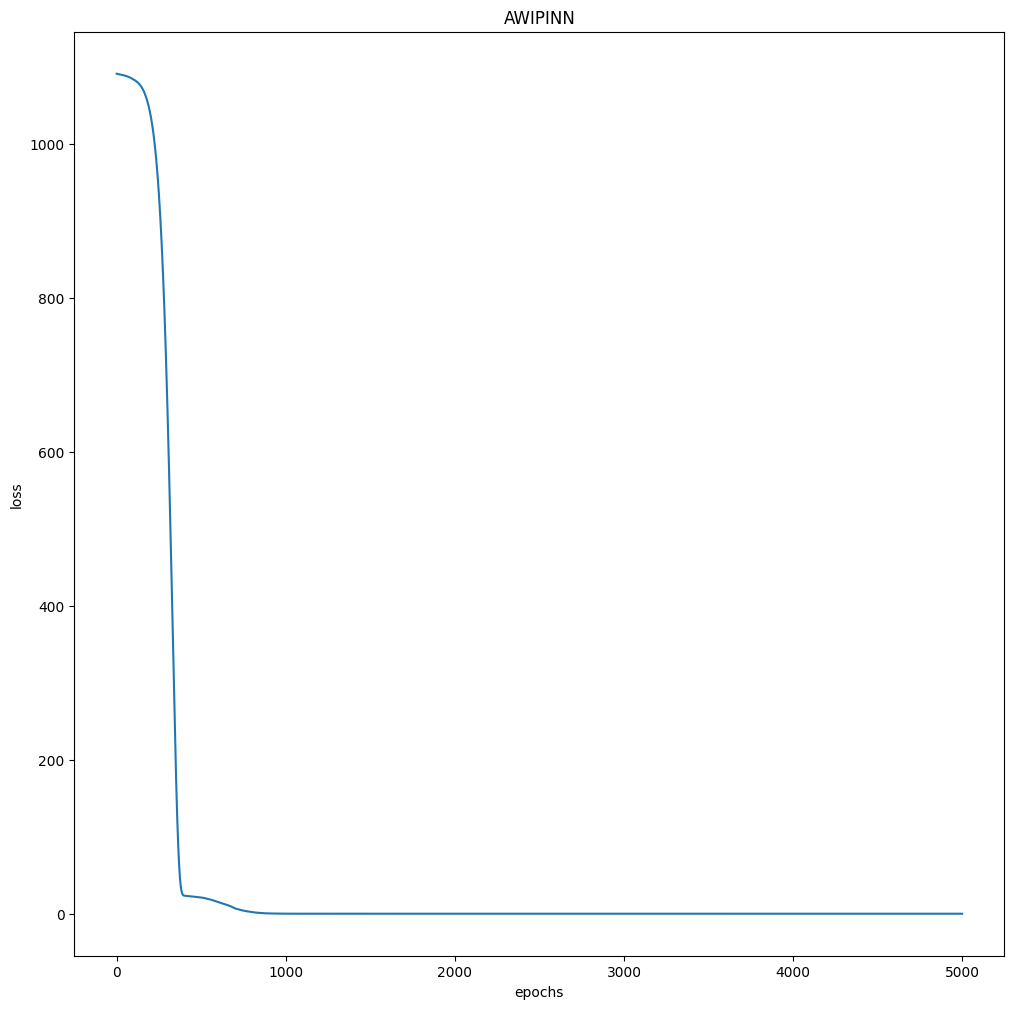

In [9]:
fig = plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('AWIPINN')

In [10]:
print(utils.test(device, IPINN))
print(min_train_loss)

AttributeError: module 'utils' has no attribute 'test'

In [ ]:
model = Net(
    sizes=[2, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0
    )
model.load_state_dict(final_model)
model.eval()
model.to(device)
print(utils.test(device, model))